# This notebook contains all our code to create and train the various multiplmodal architecture for the purpose of Image Captioning.

# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Flicker8k Dataset

In [ ]:
!wget -P Flicker/ https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!unzip Flicker/Flickr8k_Dataset

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/Flicker8k_Dataset/._342872408_04a2832a1b.jpg  
  inflating: Flicker8k_Dataset/3429142249_d09a32e291.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429142249_d09a32e291.jpg  
  inflating: Flicker8k_Dataset/3429194423_98e911a101.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429194423_98e911a101.jpg  
  inflating: Flicker8k_Dataset/3429351222_17ae744daf.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429351222_17ae744daf.jpg  
  inflating: Flicker8k_Dataset/3429351964_531de1bf16.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429351964_531de1bf16.jpg  
  inflating: Flicker8k_Dataset/3429391520_930b153f94.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429391520_930b153f94.jpg  
  inflating: Flicker8k_Dataset/3429465163_fb8ac7ce7f.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429465163_fb8ac7ce7f.jpg  
  inflating: Flicker8k_Dataset/3429581486_4556471d1a.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._34295

In [ ]:
!wget -P Flicker/ https://www.kaggle.com/datasets/adityajn105/flickr30k
!unzip Flicker/Flickr30k_Dataset

# Training Custom CNN on CIFAR100 dataset

In [95]:
#imports
import torch
import torchvision
import torchvision.transforms as transforms
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models

In [ ]:
transform = transforms.Compose([
    transforms.Resize(226),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

In [ ]:
#Import Dataset
train_data = datasets.CIFAR100('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR100('data', train=False,
                             download=True, transform=transform)

In [ ]:
print(train_data.classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Data Preprocessing

In [ ]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 2
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation


# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

# specify the image classes
classes = train_data.classes


# Create Custom CNN

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(512)
        self.conv4 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(1024)
        self.conv5 = nn.Conv2d(1024, 2048, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(2048)

        # Classification layer
        self.fc = nn.Linear(49 * 2048, 10)  # num_classes should be defined as per your classification task

    def forward(self, x):
        # Apply convolutions and pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # [batch, 64, 112, 112]
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # [batch, 256, 56, 56]
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # [batch, 512, 28, 28]
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # [batch, 1024, 14, 14]
        x = F.relu(self.bn5(self.conv5(x)))             # [batch, 2048, 7, 7]

        # Permute and reshape to match [batch, 49, 2048]
        x = x.permute(0, 2, 3, 1)                       # [batch, 7, 7, 2048]
        x = x.view(x.size(0), -1, x.size(-1))           # [batch, 49, 2048]

        # print(x.shape)
        # Classification layer (if needed)
        x = x.reshape(x.size(0), -1)
        # x = x.view(x.size(0), -1)                      # Flatten for classification
        x = self.fc(x)                                 # [batch, num_classes]

        return x

In [ ]:
model = CustomCNN()
print(model)

In [ ]:
import torch.optim as optim
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=.01)

In [ ]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf

for epoch in range(1, n_epochs):
    train_loss = 0.0
    valid_loss = 0.0

    model.train()
    for data, target in train_loader:
        # data, target = data, target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        # print(f"Train Loss: {loss.item()}")

    model.eval()
    for data, target in valid_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item() * data.size(0)
        # print(f"Valid Loss: {loss.item()}")

    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)
    print(f"Epoch: {epoch} \tTraining Loss: {train_loss} \tValidation Loss: {valid_loss}")

    if epoch % 5 == 0:
      path_to_save_cnn = '/content/drive/My Drive/Colab Notebooks/custom_cifar_100_cnn_net_weights_%s.pth' %epoch
      torch.save(model.state_dict(), path_to_save_cnn)



# FLicker Dataset

# Data preprocessing

In [ ]:
#imports
import os
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T
#using spacy for the better text tokenization
spacy_eng = spacy.load("en_core_web_sm")
import pandas as pd
from PIL import Image

In [ ]:
class Generate_Vocab():
    def __init__(self,frequency_cutoff):

        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        self.stoi = {v:k for k,v in self.itos.items()}

        self.frequency_cutoff = frequency_cutoff

    def __len__(self): return len(self.itos)

    @staticmethod
    def tokenize(sentence):
        return [word.text.lower() for word in spacy_eng.tokenizer(sentence)]

    def vocab_builder(self, sentences):
        frequencies = Counter()
        index = 4

        for sent in sentences:
            for word in self.tokenize(sent):
                frequencies[word] += 1

                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.frequency_cutoff:
                    self.stoi[word] = index
                    self.itos[index] = word
                    index += 1

    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(text)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]

In [ ]:
class FlickrDataset(Dataset):
    """
    FlickrDataset
    """
    def __init__(self,root_dir,captions_file,transform=None,frequency_cutoff=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        #Get image and caption colum from the dataframe
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        #Initialize vocabulary and build vocab
        self.vocab = Generate_Vocab(frequency_cutoff)
        self.vocab.vocab_builder(self.captions.tolist())


    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")

        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)

        #numericalize the caption text
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]

        return img, torch.tensor(caption_vec)

In [ ]:
class PaddingClass:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)

        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

In [ ]:
#show the tensor image
import matplotlib.pyplot as plt
def show_image(img, title=None):
    """Imshow for Tensor."""

    #unnormalize
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224
    img[2] = img[2] * 0.225
    img[0] += 0.485
    img[1] += 0.456
    img[2] += 0.406

    img = img.numpy().transpose((1, 2, 0))


    plt.imshow(img)
    if title is not None:
        plt.title(title)

In [ ]:
from torch.utils.data import Subset
import torch
import numpy as np

def train_test_split(dataset, test_split=0.2):
    # Create a list of indices from 0 to len(dataset)
    indices = list(range(len(dataset)))

    # Shuffle indices
    np.random.shuffle(indices)

    # Calculate the split index
    split = int(np.floor(test_split * len(dataset)))

    # Split indices into training and test sets
    train_indices, test_indices = indices[split:], indices[:split]

    # Create subsets
    train_dataset = Subset(dataset, train_indices)
    test_dataset = Subset(dataset, test_indices)

    return train_dataset, test_dataset



In [ ]:
BATCH_SIZE = 32
NUM_WORKER = 4

#defining the transform to be applied
transforms = T.Compose([
    T.Resize(226),
    T.RandomCrop(224),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])


# creatinf the dataset class
dataset =  FlickrDataset(
    root_dir = "Flicker8k_Dataset",
    captions_file = "captions.txt",
    transform=transforms
)

train_dataset, test_dataset = train_test_split(dataset)

print(len(train_dataset))
print(len(test_dataset))


32364
8091


In [ ]:
#token to represent the padding
pad_idx = dataset.vocab.stoi["<PAD>"]

# writing the dataloader
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=PaddingClass(pad_idx=pad_idx,batch_first=True),
    # batch_first=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=PaddingClass(pad_idx=pad_idx,batch_first=True),
    # batch_first=False
)


#vocab_size
vocab_size = len(dataset.vocab)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


device(type='cuda', index=0)

#Creating DataLoaders for Flicker30k Dataset

In [ ]:

# creatinf the dataset class
flicker30k_dataset =  FlickrDataset(
    root_dir = "Flicker30k_Dataset",
    captions_file = "Flicker30k_captions.txt",
    transform=transforms
)

flicker30k_train_dataset, flicker30k_test_dataset = train_test_split(flicker30k_dataset)


#token to represent the padding
pad_idx = dataset.vocab.stoi["<PAD>"]

# writing the dataloader
flicker30k_train_loader = DataLoader(
    dataset=flicker30k_train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=PaddingClass(pad_idx=pad_idx,batch_first=True),
    # batch_first=False
)

flicker30k_test_loader = DataLoader(
    dataset=flicker30k_test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=PaddingClass(pad_idx=pad_idx,batch_first=True),
    # batch_first=False
)


#vocab_size
flicker30k_vocab_size = len(flicker30k_dataset.vocab)

# Models

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

# RESNET50

In [ ]:
class ResNetEncoderCNN(nn.Module):
    def __init__(self):
        super(ResNetEncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)


    def forward(self, images):
        features = self.resnet(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features


# VGG 16

In [ ]:
class VGGEncoderCNN(nn.Module):
    def __init__(self):
        super(VGGEncoderCNN, self).__init__()
        vgg16 = models.vgg16(pretrained=True)
        # Remove the fully connected layers (classifier)
        self.features = vgg16.features

     # Add an additional convolutional layer to reduce channels to 2048
        self.extra_conv = nn.Conv2d(512, 2048, kernel_size=1, stride=1, padding=0)

    def forward(self, images):
        # Forward pass through the VGG16 features
        features = self.features(images)
        # Apply the extra convolutional layer
        features = self.extra_conv(features)
        # Reshape to match the desired output shape [batch_size, 49, 2048]
        batch_size, channels, height, width = features.size()
        features = features.view(batch_size, channels, height * width)
        features = features.permute(0, 2, 1)  # Swap dimensions
        return features

#Custom CNN

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(512)
        self.conv4 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(1024)
        self.conv5 = nn.Conv2d(1024, 2048, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(2048)

        # Classification layer
        self.fc = nn.Linear(49 * 2048, 100)  # num_classes should be defined as per your classification task

    def forward(self, x):
        # Apply convolutions and pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # [batch, 64, 112, 112]
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # [batch, 256, 56, 56]
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # [batch, 512, 28, 28]
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # [batch, 1024, 14, 14]
        x = F.relu(self.bn5(self.conv5(x)))             # [batch, 2048, 7, 7]

        # Permute and reshape to match [batch, 49, 2048]
        x = x.permute(0, 2, 3, 1)                       # [batch, 7, 7, 2048]
        x = x.view(x.size(0), -1, x.size(-1))           # [batch, 49, 2048]

        return x

In [ ]:

class Attention_Layer(nn.Module):
    def __init__(self, enc_dimensions,dec_dimensions,att_dimensions):
        super(Attention_Layer, self).__init__()

        self.att_dimensions = att_dimensions

        self.transform_decoder_dims = nn.Linear(dec_dimensions,att_dimensions)
        self.transform_encoder_dims = nn.Linear(enc_dimensions,att_dimensions)

        self.Attention_Score = nn.Linear(att_dimensions,1)


    def forward(self, features, hidden_state):
        encoder_Scores = self.transform_encoder_dims(features)
        decoder_Scores = self.transform_decoder_dims(hidden_state)

        combined_states = torch.tanh(encoder_Scores + decoder_Scores.unsqueeze(1))

        attention_scores = self.Attention_Score(combined_states)
        attention_scores = attention_scores.squeeze(2)


        alpha = F.softmax(attention_scores,dim=1)

        attention_weights = features * alpha.unsqueeze(2)
        attention_weights = attention_weights.sum(dim=1)

        return alpha,attention_weights

In [ ]:
#Attention Decoder
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()


        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim

        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention_Layer(encoder_dim,decoder_dim,attention_dim)


        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)


        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)



    def forward(self, features, captions):

        #vectorize the caption
        embeds = self.embedding(captions)

        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)

        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)

        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)

        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))

            output = self.fcn(self.drop(h))

            preds[:,s] = output
            alphas[:,s] = alpha


        return preds, alphas

    def generate_caption(self,features,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions

        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)

        alphas = []

        #starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)


        captions = []

        for i in range(max_len):
            alpha,context = self.attention(features, h)


            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())

            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)


            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)

            #save the generated word
            captions.append(predicted_word_idx.item())

            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break

            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))

        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions],alphas


    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

In [ ]:
class DecoderRNNWithoutAttention(nn.Module):
    def __init__(self, embed_size, vocab_size, encoder_dim, decoder_dim, drop_prob=0.3):
        super(DecoderRNN, self).__init__()

        # Model parameters
        self.vocab_size = vocab_size
        self.decoder_dim = decoder_dim

        # Embedding layer for the vocabulary
        self.embedding = nn.Embedding(vocab_size, embed_size)

        # Initialize hidden and cell state
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)

        # Define the LSTM cell
        self.lstm_cell = nn.LSTMCell(embed_size + encoder_dim, decoder_dim, bias=True)

        # Fully connected output layer
        self.fcn = nn.Linear(decoder_dim, vocab_size)

        # Dropout layer
        self.drop = nn.Dropout(drop_prob)

    def forward(self, features, captions):
        # Vectorize the caption
        embeds = self.embedding(captions)

        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)

        # Get the sequence length to iterate through
        seq_length = len(captions[0]) - 1  # Exclude <EOS>
        batch_size = captions.size(0)

        # Placeholder for predictions
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)

        for s in range(seq_length):
            # Combine embedded input word and features from the encoder
            lstm_input = torch.cat((embeds[:, s], features.mean(dim=1)), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))

            # Compute the output
            output = self.fcn(self.drop(h))
            preds[:, s] = output

        return preds

    def generate_caption(self, features, max_len=20, vocab=None):
        # Inference part to generate captions given image features

        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)

        # Starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1, -1).to(device)
        embeds = self.embedding(word)

        captions = []

        for i in range(max_len):
            lstm_input = torch.cat((embeds[:, 0], features.mean(dim=1)), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size, -1)

            # Select the word with the highest value
            predicted_word_idx = output.argmax(dim=1)
            captions.append(predicted_word_idx.item())

            # End if <EOS> detected
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break

            # Send generated word as the next input to the LSTM cell
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))

        # Convert the vocab indices to words and return the sentence
        return [vocab.itos[idx] for idx in captions]

    def init_hidden_state(self, encoder_out):
        # Initialize hidden and cell states with mean encoder output
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c

# HyperParamters

In [ ]:
#Hyperparams
embed_size=300
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 0.01

# Resnet Encoder-Decoder

In [ ]:
class ResnetEncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = ResNetEncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [ ]:
ResnetEncoderDecodermodel = ResnetEncoderDecoder(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 110MB/s]


In [ ]:
class ResnetEncoderDecoderWithoutAttention(nn.Module):
    def __init__(self,embed_size, vocab_size,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = ResNetEncoderCNN()
        self.decoder = DecoderRNNWithoutAttention(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [ ]:
ResnetEncoderDecoderWithoutAttentionmodel = ResnetEncoderDecoderWithoutAttention(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    encoder_dim=2048,
    decoder_dim=512
).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(ResnetEncoderDecodermodel.parameters(), lr=learning_rate)

#Training on Flicker8k

In [ ]:
num_epochs = 21
print_every = 800
lossesResnet8k = []
for epoch in range(1,num_epochs+1):
    for idx, (image, captions) in enumerate(iter(train_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = ResnetEncoderDecodermodel(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()


        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            lossesResnet8k.append(loss.item())


            #generate the caption
            ResnetEncoderDecodermodel.eval()
            with torch.no_grad():
                dataiter = iter(test_loader)
                img,_ = next(dataiter)
                features = ResnetEncoderDecodermodel.encoder(img[0:1].to(device))
                caps,alphas = ResnetEncoderDecodermodel.decoder.generate_caption(features,vocab=dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)

            ResnetEncoderDecodermodel.train()
    if epoch % 5 == 0:
      path_to_save_cnn = '/content/drive/My Drive/Colab Notebooks/resnet_cnn_weights_%s.pth' %epoch
      torch.save(ResnetEncoderDecodermodel.state_dict(), path_to_save_cnn)



#Training in Flickr8k without Attention


In [ ]:
num_epochs = 21
print_every = 800
lossesResnet8kWithoutAttention = []
for epoch in range(1,num_epochs+1):
    for idx, (image, captions) in enumerate(iter(train_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = ResnetEncoderDecoderWithoutAttentionmodel(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()


        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            lossesResnet8kWithoutAttention.append(loss.item())


            #generate the caption
            ResnetEncoderDecoderWithoutAttentionmodel.eval()
            with torch.no_grad():
                dataiter = iter(test_loader)
                img,_ = next(dataiter)
                features = ResnetEncoderDecoderWithoutAttentionmodel.encoder(img[0:1].to(device))
                caps,alphas = ResnetEncoderDecoderWithoutAttentionmodel.decoder.generate_caption(features,vocab=dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)

            ResnetEncoderDecoderWithoutAttentionmodel.train()
    if epoch % 5 == 0:
      path_to_save_cnn = '/content/drive/My Drive/Colab Notebooks/resnet_cnn_weights_without_attention_%s.pth' %epoch
      torch.save(ResnetEncoderDecoderWithoutAttentionmodel.state_dict(), path_to_save_cnn)



# Training on Flicker30k

In [ ]:
num_epochs = 21
print_every = 800
lossesResnet30k = {}
for epoch in range(1,num_epochs+1):
    for idx, (image, captions) in enumerate(iter(flicker30k_train_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = ResnetEncoderDecodermodel(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()


        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            lossesResnet30k.append(loss.item())


            #generate the caption
            ResnetEncoderDecodermodel.eval()
            with torch.no_grad():
                dataiter = iter(flicker30k_test_loader)
                img,_ = next(dataiter)
                features = ResnetEncoderDecodermodel.encoder(img[0:1].to(device))
                caps,alphas = ResnetEncoderDecodermodel.decoder.generate_caption(features,vocab=flicker30k_dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)

            ResnetEncoderDecodermodel.train()
    if epoch % 5 == 0:
      path_to_save_cnn = '/content/drive/My Drive/Colab Notebooks/flicker30k_resnet_cnn_weights_%s.pth' %epoch
      torch.save(ResnetEncoderDecodermodel.state_dict(), path_to_save_cnn)



# VGG Encoder-Decoder

In [ ]:
class VGGEncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = VGGEncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [ ]:
VGGEncoderDecodermodel = VGGEncoderDecoder(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 156MB/s]


In [ ]:
class VGGEncoderDecoderWithoutAttention(nn.Module):
    def __init__(self,embed_size, vocab_size,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = VGGEncoderCNN()
        self.decoder = DecoderRNNWithoutAttention(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [ ]:
VGGEncoderDecoderWithoutAttentionmodel = VGGEncoderDecoderWithoutAttention(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    encoder_dim=2048,
    decoder_dim=512
).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(VGGEncoderDecodermodel.parameters(), lr=learning_rate)

#Training on Flicker8k

In [ ]:
num_epochs = 21
print_every = 800
lossesVGG8k = {}
for epoch in range(1,num_epochs+1):
    for idx, (image, captions) in enumerate(iter(train_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = VGGEncoderDecodermodel(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()


        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            lossesVGG8k.append(loss.item())


            #generate the caption
            VGGEncoderDecodermodel.eval()
            with torch.no_grad():
                dataiter = iter(test_loader)
                img,_ = next(dataiter)
                features = VGGEncoderDecodermodel.encoder(img[0:1].to(device))
                caps,alphas = VGGEncoderDecodermodel.decoder.generate_caption(features,vocab=dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)

            VGGEncoderDecodermodel.train()
    if epoch % 5 == 0:
      path_to_save_cnn = '/content/drive/My Drive/Colab Notebooks/vgg_cnn_weights_%s.pth' %epoch
      torch.save(VGGEncoderDecodermodel.state_dict(), path_to_save_cnn)



#Training on Flicker8k without Attention

In [ ]:
num_epochs = 21
print_every = 800
lossesVGG8kWithoutAttention = {}
for epoch in range(1,num_epochs+1):
    for idx, (image, captions) in enumerate(iter(train_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = VGGEncoderDecoderWithoutAttentionmodel(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()


        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            lossesVGG8kWithoutAttention.append(loss.item())


            #generate the caption
            VGGEncoderDecoderWithoutAttentionmodel.eval()
            with torch.no_grad():
                dataiter = iter(test_loader)
                img,_ = next(dataiter)
                features = VGGEncoderDecoderWithoutAttentionmodel.encoder(img[0:1].to(device))
                caps,alphas = VGGEncoderDecoderWithoutAttentionmodel.decoder.generate_caption(features,vocab=dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)

            VGGEncoderDecoderWithoutAttentionmodel.train()
    if epoch % 5 == 0:
      path_to_save_cnn = '/content/drive/My Drive/Colab Notebooks/vgg_cnn_weights_without_attention_%s.pth' %epoch
      torch.save(VGGEncoderDecoderWithoutAttentionmodel.state_dict(), path_to_save_cnn)



#Training on Flicker30k

In [ ]:
num_epochs = 21
print_every = 800
lossesVGG30k = {}
for epoch in range(1,num_epochs+1):
    for idx, (image, captions) in enumerate(iter(flicker30k_train_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = VGGEncoderDecodermodel(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()


        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            lossesVGG30k.append(loss.item())


            #generate the caption
            VGGEncoderDecodermodel.eval()
            with torch.no_grad():
                dataiter = iter(flicker30k_test_loader)
                img,_ = next(dataiter)
                features = VGGEncoderDecodermodel.encoder(img[0:1].to(device))
                caps,alphas = VGGEncoderDecodermodel.decoder.generate_caption(features,vocab=flicker30k_dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)

            VGGEncoderDecodermodel.train()
    if epoch % 5 == 0:
      path_to_save_cnn = '/content/drive/My Drive/Colab Notebooks/flicker30k_vgg_cnn_weights_%s.pth' %epoch
      torch.save(VGGEncoderDecodermodel.state_dict(), path_to_save_cnn)



#Custom CNN Encoder-Decoder

In [ ]:
class CustomCNNEncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = CustomCNN()
        path_to_custom_model_weights = '/content/drive/My Drive/CS5100/custom_cifar_cnn_net_weights_20.pth'
        self.encoder.load_state_dict(torch.load(path_to_custom_model_weights))
        self.encoder.eval()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [ ]:
CustomCNNEncoderDecodermodel = CustomCNNEncoderDecoder(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)

In [ ]:
class CustomCNNEncoderDecoderWithoutAttention(nn.Module):
    def __init__(self,embed_size, vocab_size,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = CustomCNN()
        path_to_custom_model_weights = '/content/drive/My Drive/CS5100/custom_cifar_cnn_net_weights_20.pth'
        self.encoder.load_state_dict(torch.load(path_to_custom_model_weights))
        self.encoder.eval()
        self.decoder = DecoderRNNWithoutAttention(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [ ]:
CustomCNNEncoderDecoderWithoutAttentionmodel = CustomCNNEncoderDecoderWithoutAttention(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    encoder_dim=2048,
    decoder_dim=512
).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(VGGEncoderDecodermodel.parameters(), lr=learning_rate)

#Training on Flicker8k

In [ ]:
num_epochs = 21
print_every = 800
lossesCustom8k = {}
for epoch in range(1,num_epochs+1):
    for idx, (image, captions) in enumerate(iter(train_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = CustomCNNEncoderDecodermodel(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()


        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            lossesCustom8k.append(loss.item())


            #generate the caption
            CustomCNNEncoderDecodermodel.eval()
            with torch.no_grad():
                dataiter = iter(test_loader)
                img,_ = next(dataiter)
                features = CustomCNNEncoderDecodermodel.encoder(img[0:1].to(device))
                caps,alphas = CustomCNNEncoderDecodermodel.decoder.generate_caption(features,vocab=dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)

            CustomCNNEncoderDecodermodel.train()
    if epoch % 5 == 0:
      path_to_save_cnn = '/content/drive/My Drive/Colab Notebooks/custom_cnn_weights_%s.pth' %epoch
      torch.save(CustomCNNEncoderDecodermodel.state_dict(), path_to_save_cnn)



#Training on Flicker8k without Attention

In [ ]:
num_epochs = 21
print_every = 800
lossesCustom8kWithoutAttention = {}
for epoch in range(1,num_epochs+1):
    for idx, (image, captions) in enumerate(iter(train_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = CustomCNNEncoderDecoderWithoutAttentionmodel(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()


        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            lossesCustom8kWithoutAttention.append(loss.item())


            #generate the caption
            CustomCNNEncoderDecoderWithoutAttentionmodel.eval()
            with torch.no_grad():
                dataiter = iter(test_loader)
                img,_ = next(dataiter)
                features = CustomCNNEncoderDecoderWithoutAttentionmodel.encoder(img[0:1].to(device))
                caps,alphas = CustomCNNEncoderDecoderWithoutAttentionmodel.decoder.generate_caption(features,vocab=dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)

            CustomCNNEncoderDecoderWithoutAttentionmodel.train()
    if epoch % 5 == 0:
      path_to_save_cnn = '/content/drive/My Drive/Colab Notebooks/custom_cnn_weights_without_attention_%s.pth' %epoch
      torch.save(CustomCNNEncoderDecoderWithoutAttentionmodel.state_dict(), path_to_save_cnn)



#Training on Flicker30k

In [ ]:
num_epochs = 21
print_every = 800
lossesCustom30k = {}
for epoch in range(1,num_epochs+1):
    for idx, (image, captions) in enumerate(iter(flicker30k_train_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = CustomCNNEncoderDecodermodel(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()


        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            lossesCustom30k.append(loss.item())


            #generate the caption
            CustomCNNEncoderDecodermodel.eval()
            with torch.no_grad():
                dataiter = iter(flicker30k_test_loader)
                img,_ = next(dataiter)
                features = CustomCNNEncoderDecodermodel.encoder(img[0:1].to(device))
                caps,alphas = CustomCNNEncoderDecodermodel.decoder.generate_caption(features,vocab=flicker30k_dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)

            CustomCNNEncoderDecodermodel.train()
    if epoch % 5 == 0:
      path_to_save_cnn = '/content/drive/My Drive/Colab Notebooks/flicker30k_custom_cnn_weights_%s.pth' %epoch
      torch.save(CustomCNNEncoderDecodermodel.state_dict(), path_to_save_cnn)



# Plotiing graphs

# Flicker8k

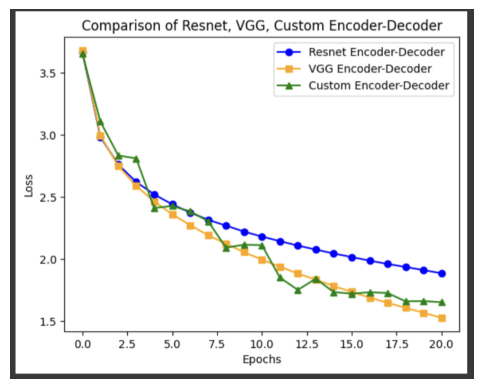

In [100]:
# Plotting the graph
plt.plot(lossesResnet8k, 'o-', label='Resnet Encoder-Decoder', color='blue')
plt.plot(lossesVGG8k, 's-', label='VGG Encoder-Decoder', color='orange')
plt.plot(lossesCustom8k, '^-', label='Custom CNN Encoder-Decoder', color='green')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Resnet, VGG and CustomCNN Encoder-Decoder')
plt.legend()

# Display the plot
plt.show()


#Flickr8k Without Attention

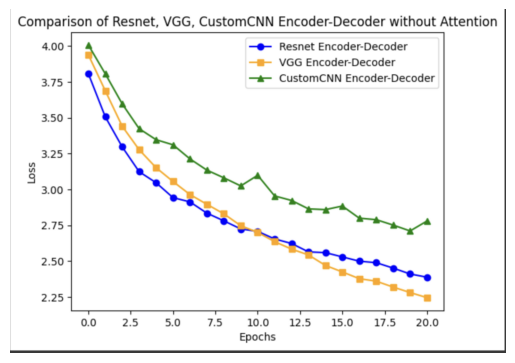

In [102]:
# Plotting the graph
plt.plot(lossesResnet8kWithoutAttention, 'o-', label='Resnet Encoder-Decoder', color='blue')
plt.plot(lossesVGG8kWithoutAttention, 's-', label='VGG Encoder-Decoder', color='orange')
plt.plot(lossesCustom8kWithoutAttention, '^-', label='Custom CNN Encoder-Decoder', color='green')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Resnet, VGG and CustomCNN Encoder-Decoder without attention')
plt.legend()

# Display the plot
plt.show()


#Flicker30k

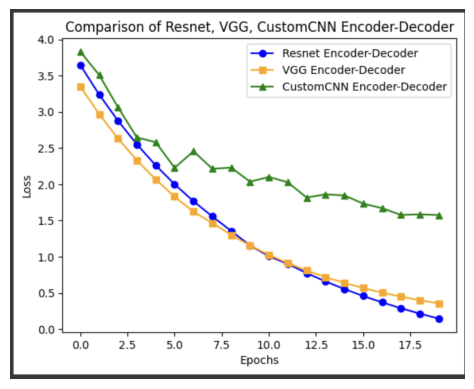

In [99]:
# Plotting the graph
plt.plot(lossesResnet30k, 'o-', label='Resnet Encoder-Decoder', color='blue')
plt.plot(lossesVGG30k, 's-', label='VGG Encoder-Decoder', color='orange')
plt.plot(lossesCustom30k, '^-', label='Custom CNN Encoder-Decoder', color='green')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Resnet, VGG and CustomCNN Encoder-Decoder')
plt.legend()

# Display the plot
plt.show()


# Outputs

In [ ]:
#generate caption
def get_caps_from(features_tensors,model):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        # show_image(features_tensors[0],title=caption)

    return caps,alphas

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224
    img[2] = img[2] * 0.225
    img[0] += 0.485
    img[1] += 0.456
    img[2] += 0.406

    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)

        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())


    plt.tight_layout()
    plt.show()

13
-----------Resnet------------


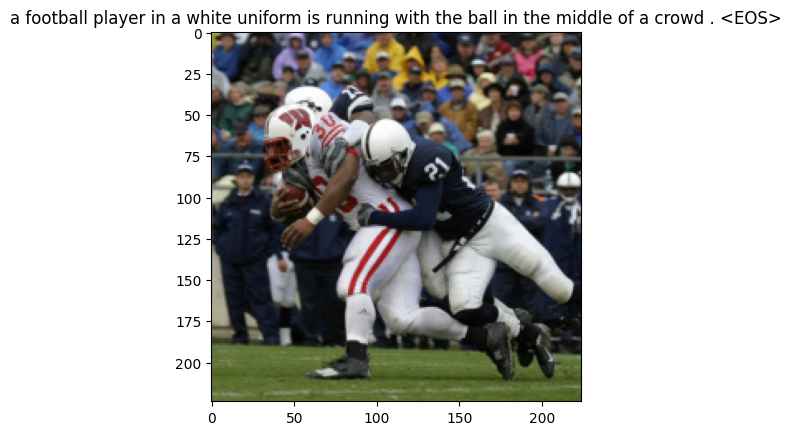

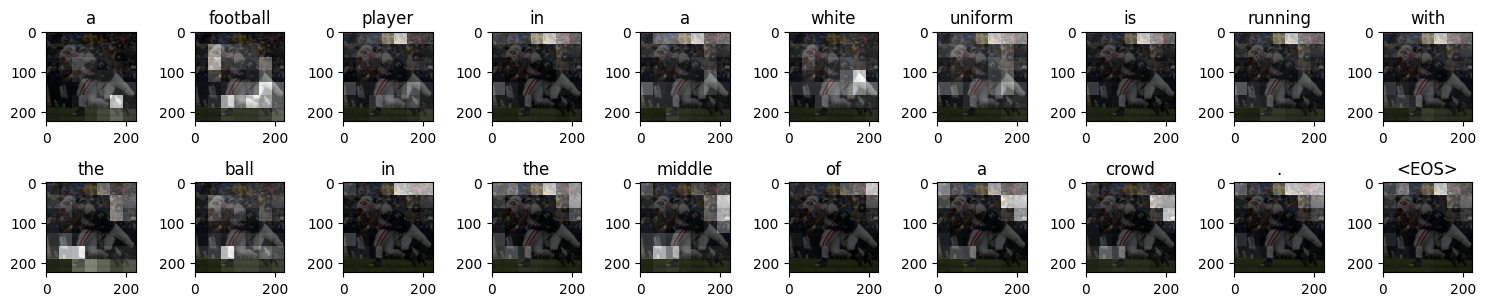

-----------VGG------------


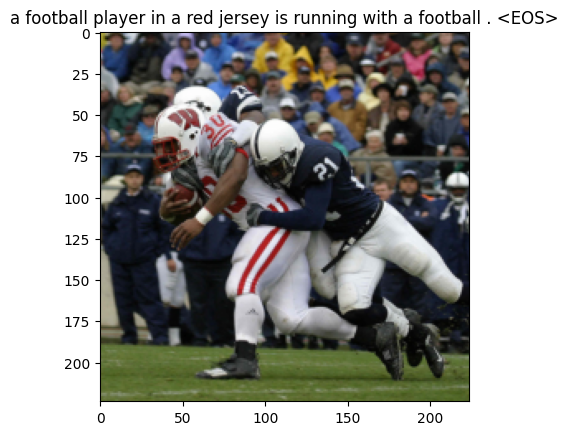

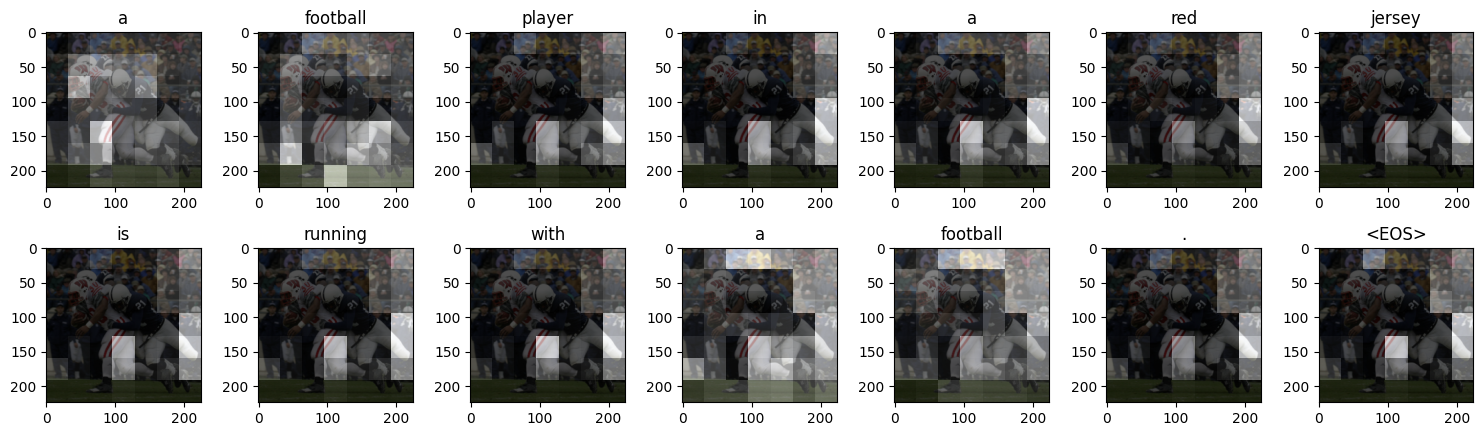

-----------Custom------------


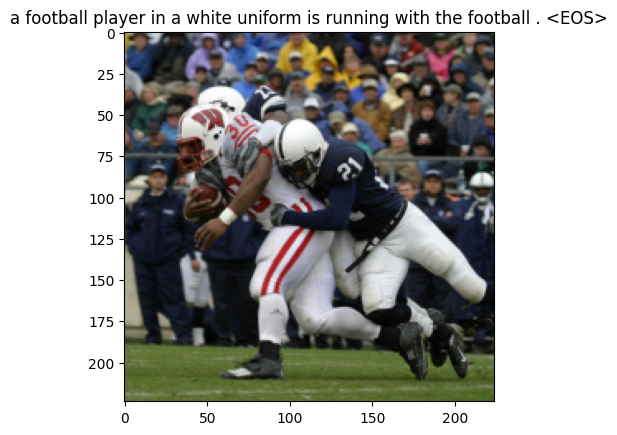

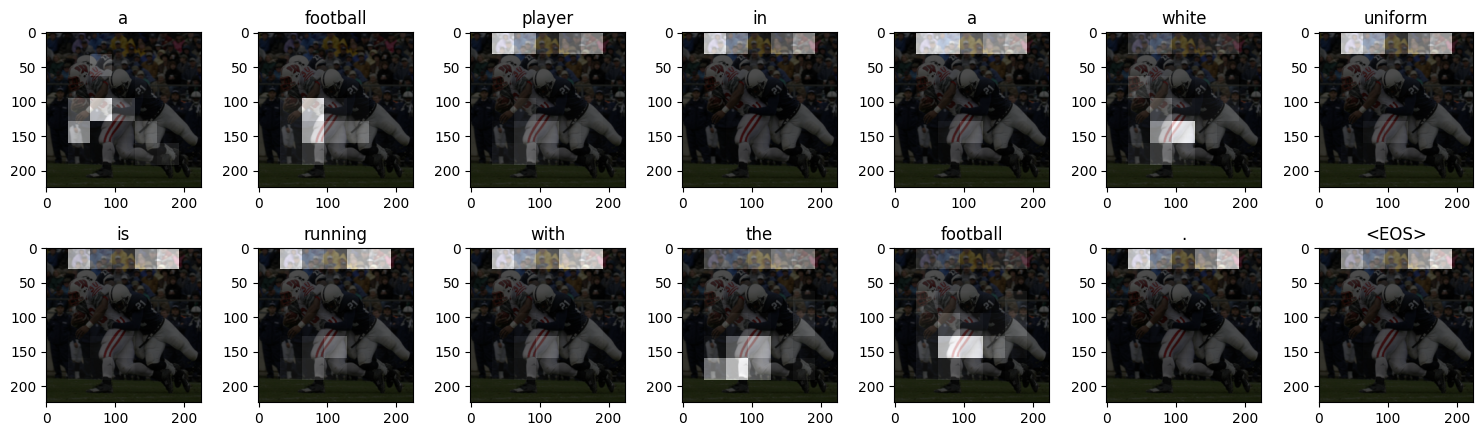

In [ ]:
import random
import math
random_index = math.floor(random.random() * 32)


dataiter = iter(test_loader)
images,_ = next(dataiter)

print(random_index)

img = images[random_index].detach().clone()
img1 = images[random_index].detach().clone()

path_to_resnet_model_weights = '/content/drive/My Drive/CS5100/resnet_cnn_weights_20.pth'
ResnetEncoderDecodermodel.load_state_dict(torch.load(path_to_resnet_model_weights))

print("-----------Resnet------------")
#Resnet
caps,alphas = get_caps_from(img.unsqueeze(0),ResnetEncoderDecodermodel)
plot_attention(img1, caps, alphas)


img = images[random_index].detach().clone()
img1 = images[random_index].detach().clone()

path_to_vgg_model_weights = '/content/drive/My Drive/CS5100/vgg_cnn_weights_20.pth'
VGGEncoderDecodermodel.load_state_dict(torch.load(path_to_vgg_model_weights))

print("-----------VGG------------")
#VGG
caps,alphas = get_caps_from(img.unsqueeze(0),VGGEncoderDecodermodel)
plot_attention(img1, caps, alphas)

img = images[random_index].detach().clone()
img1 = images[random_index].detach().clone()

path_to_custom_model_weights = '/content/drive/My Drive/CS5100/custom_cnn_weights_10.pth'
CustomCNNEncoderDecodermodel.load_state_dict(torch.load(path_to_custom_model_weights))

print("-----------Custom------------")
#Custom CNN
caps,alphas = get_caps_from(img.unsqueeze(0),CustomCNNEncoderDecodermodel)
plot_attention(img1, caps, alphas)

# Calculate BLEU and SPICE scores

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')

def getCaptionFromTensor(captionTensor):
  caption = ""
  for x in captionTensor:
      if dataset.vocab.itos[x.item()] in ['<SOS>','<UNK>','<PAD>']:
        continue
      caption = caption + dataset.vocab.itos[x.item()] + " "
  return caption

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
!pip install pycocotools
!git clone https://github.com/salaniz/pycocoevalcap

Cloning into 'pycocoevalcap'...
remote: Enumerating objects: 821, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 821 (delta 5), reused 19 (delta 4), pack-reused 797
Receiving objects: 100% (821/821), 130.06 MiB | 27.58 MiB/s, done.
Resolving deltas: 100% (424/424), done.


In [96]:
# Example: Evaluating BLEU score for the entire dataset

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
smoothie = SmoothingFunction().method4

dataiter = iter(test_loader)
images,captions = next(dataiter)

total_bleu_score_resnet = 0.0
total_bleu_score_vgg = 0.0
total_bleu_score_custom = 0.0


total_spice_score_resnet = 0.0
total_spice_score_vgg = 0.0
total_spice_score_custom = 0.0

num_examples = 32
reference = []


for i in range(32):


    img = images[i].detach().clone()
    captionTensor = captions[i]

    # Generate caption using your model
    caption_original = getCaptionFromTensor(captionTensor)
    caps_res,alphas = get_caps_from(img.unsqueeze(0),ResnetEncoderDecodermodel)
    caps_vgg,alphas = get_caps_from(img.unsqueeze(0),VGGEncoderDecodermodel)
    caps_custom,alphas = get_caps_from(img.unsqueeze(0),CustomCNNEncoderDecodermodel)



    # Tokenize reference captions
    reference_caption = caption_original.split(" ")#[word_tokenize(ref) for ref in caption_original.split(" ")]

    # Tokenize generated caption using stemming
    ps = PorterStemmer()
    reference_captions = [ps.stem(word.lower()) for word in word_tokenize(" ".join(reference_caption))]
    generated_tokens_res = [ps.stem(word.lower()) for word in word_tokenize(" ".join(caps_res))]
    generated_tokens_vgg = [ps.stem(word.lower()) for word in word_tokenize(" ".join(caps_vgg))]
    generated_tokens_custom = [ps.stem(word.lower()) for word in word_tokenize(" ".join(caps_custom))]



    #Lemmatise
    lemmatizer = WordNetLemmatizer()
    reference_captions_lemma = [lemmatizer.lemmatize(sent) for sent in reference_captions]
    generated_tokens_res_lemma = [lemmatizer.lemmatize(sent) for sent in generated_tokens_res]
    generated_tokens_vgg_lemma = [lemmatizer.lemmatize(sent) for sent in generated_tokens_vgg]



    # Calculate BLEU score for this example
    bleu_score_res = sentence_bleu([reference_captions_lemma], generated_tokens_res_lemma, smoothing_function=smoothie)
    bleu_score_vgg = sentence_bleu([reference_captions_lemma], generated_tokens_vgg_lemma, smoothing_function=smoothie)
    bleu_score_custom = sentence_bleu([reference_captions_lemma], generated_tokens_custom_lemma, smoothing_function=smoothie)

    # Update BLEU score
    total_bleu_score_resnet += bleu_score_res
    total_bleu_score_vgg += bleu_score_vgg
    total_bleu_score_custom += bleu_score_custom


    # Preprocessing for SPICE score
    ref = caption_original
    res_caption = " ".join(caps_res)
    vgg_caption = " ".join(caps_vgg)
    customcnn_caption = " ".join(caps_custom)

    #Create Disctionaries for BLEU score
    ground_truth = {0: [ref]}
    resnet_hypthesis = {0: [res_caption]}
    vgg_hypthesis = {0: [vgg_caption]}
    custom_hypthesis = {0: [customcnn_caption]}


    # Caluclate SPICE score
    spice_score_res,_ = spice_scorer.compute_score(ground_truth, resnet_hypthesis)
    spice_score_vgg,_ = spice_scorer.compute_score(ground_truth, vgg_hypthesis)
    spice_score_custom,_ = spice_scorer.compute_score(ground_truth, custom_hypthesis)

    #Update Spice Score
    total_spice_score_resnet += spice_score_res
    total_spice_score_vgg += spice_score_vgg
    total_spice_score_custom += spice_score_custom




#Caluclate average BLEU and SPICE score for the batch
average_bleu_score_res = total_bleu_score_resnet / num_examples
average_bleu_score_vgg = total_bleu_score_vgg / num_examples
average_bleu_score_custom = total_bleu_score_custom / num_examples

average_spice_score_res = total_spice_score_resnet / num_examples
average_spice_score_vgg = total_spice_score_vgg / num_examples
average_spice_score_custom = total_spice_score_custom / num_examples


print(f"Average BLEU Score for Resnet Encoder-Decoder: {average_bleu_score_res}")
print(f"Average BLEU Score for VGG Encoder-Decoder: {average_bleu_score_vgg}")
print(f"Average BLEU Score for Custom Encoder-Decoder: {average_bleu_score_custom}")


print(f"Average SPICE Score for Resnet Encoder-Decoder: {average_spice_score_res}")
print(f"Average SPICE Score for VGG Encoder-Decoder: {average_spice_score_vgg}")
print(f"Average SPICE Score for Custom Encoder-Decoder: {average_spice_score_custom}")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Average BLEU Score for Resnet Encoder-Decoder: 0.3114
Average BLEU Score for VGG Encoder-Decoder: 0.3697
Average BLEU Score for Custom Encoder-Decoder: 0.2694
Average SPICE Score for Resnet Encoder-Decoder: 0.3032
Average SPICE Score for VGG Encoder-Decoder: 0.3255
Average SPICE Score for Custom Encoder-Decoder: 0.2786


# Vision-Transformer

In [ ]:

# Web links Handler
import requests

# Backend
import torch

# Image Processing
from PIL import Image

# Transformer and Pretrained Model
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, GPT2TokenizerFast

# Managing loading processsing
from tqdm import tqdm

# Assign available GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Loading a fine-tuned image captioning Transformer Model

# ViT Encoder - Decoder Model
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning").to(device)

# Corresponding ViT Tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

# Image processor
image_processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

In [ ]:
# Accesssing images from the web
import urllib.parse as parse
import os
# Verify url
def check_url(string):
    try:
        result = parse.urlparse(string)
        return all([result.scheme, result.netloc, result.path])
    except:
        return False

# Load an image
def load_image(image_path):
    if check_url(image_path):
        return Image.open(requests.get(image_path, stream=True).raw)
    elif os.path.exists(image_path):
        return Image.open(image_path)

In [ ]:
# Image inference
def get_caption(model, image_processor, tokenizer, image_path):
    image = load_image(image_path)

    # Preprocessing the Image
    img = image_processor(image, return_tensors="pt").to(device)

    # Generating captions
    output = model.generate(**img)

    # decode the output
    caption = tokenizer.batch_decode(output, skip_special_tokens=True)[0]

    return caption

In [ ]:
#  Image media display
from IPython.display import display

In [ ]:
# Loading URLs
url = "https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.nationalgeographic.org%2Fencyclopedia%2Fsurfing%2F&psig=AOvVaw3RsV183hdo2lSP7ABgV1h7&ust=1702329650539000&source=images&cd=vfe&opi=89978449&ved=0CBIQjRxqFwoTCOCyraXmhYMDFQAAAAAdAAAAABAD"

# Display Image
display(load_image(url))

# Display Caption
get_caption(model, image_processor, tokenizer, url)